In [598]:
import csv
import pandas as pd
df_02_01 = pd.read_csv("MD-0002-00000001.csv")
df_02_02 = pd.read_csv("MD-0002-00000002.csv")
df_02_03 = pd.read_csv("MD-0002-00000003.csv")
df_04_01 = pd.read_csv("MD-0004-00000001.csv")
df_04_02 = pd.read_csv("MD-0004-00000002.csv")

In [641]:
import numpy as np
import matplotlib.pyplot as plt
from mip import Model, xsum, maximize, minimize, BINARY
import networkx as nx
from sklearn.cluster import KMeans
from kneed import KneeLocator
from timeit import default_timer as timer

#this function returns an affinity matrix based on the dataframes.
def m_maker(R,S,df):
    n=0
    A=np.zeros((R,S))
    while(n!=R):
        located=df.loc[df['Reviewer id'] == n]
        for i, row in located.iterrows():
            if row['Bid'] == 'yes':
                A[n][row['Submission number']] = 3
            elif row['Bid'] == 'maybe':
                A[n][row['Submission number']] = 2
            elif row['Bid'] == 'no':
                A[n][row['Submission number']] = 1
            else:
                A[n][row['Submission number']] = 0
        n+=1
    n=0
    return A

In [608]:
#linear programming optimizer
def optimizer(A, R, S, load, coverage, egal_bot=0, diverse='no', divlist={}):
    m = Model(sense=maximize)

    B = [[m.add_var(var_type=BINARY) for j in range(S)] for i in range(R)]

    AB = xsum(A[i][j]*B[i][j] for i in range(R) for j in range(S))

    m.objective = maximize(AB)

    for j in range(S):
        m += xsum(B[i][j] for i in range(R)) >= 2
        m += xsum(B[i][j] for i in range(R)) <= coverage

    for i in range(R):
        for j in range(S):
            if A[i][j] == 0:
                m += B[i][j] == 0

    for i in range(R):
        l= xsum(B[i][j] for j in range(S))
        m += l >= 1
        m += l <= load
    
    for i in range(R):
        m+=xsum(A[i][j]*B[i][j] for j in range(S)) >= egal_bot
        
    if diverse=="yes":
        for a in range(S):
            for i in divlist.keys():
                m += xsum(B[j][a] for j in divlist[i]) <= 1

    m.optimize()
    r=[x for x in range(0, R)]
    r={el:[] for el in r}
    for i in range(R):
        for j in range(S):
            if (B[i][j].x>=0.99):
                r[i].append(j)
    return r
    

In [601]:
#to get all scores for papers and reviewers.
def utility_score(dic, A):
    ut=[]
    for rev in dic:
        s_score=0
        sub=dic[rev]
        for i in sub:
            s_score+=A[rev][i]
        ut.append(s_score)
    return ut

def new_dic(dic,R,P):
    r=[x for x in range(0, R)]
    r={el:[] for el in r}
    for i in range(R):
        for j in range(P):
            if i in dic[j]:
                r[i].append(j)
    return r

def r_to_pap(dic, R,P):
    r=[x for x in range(0, P)]
    r={el:[] for el in r}
    for i in range(P):
        for j in range(R):
            if i in dic[j]:
                r[i].append(j)
    return r

def utility_score_pap(dic, A):
    ut=[]
    for rev in dic:
        s_score=0
        sub=dic[rev]
        for i in sub:
            s_score+=A[i][rev]
        ut.append(s_score)
    return ut
         

In [603]:
#These functions make use of the kmeans clustering algorithm to determine the right cluster amount, and to divide the scores.

kmeans = {
    "init": "random",
    "n_init":10,
    "max_iter": 300,
    "random_state": 42}


def groups(A, kmeans):
    sse=[]
    for k in range(1, 21):
        kmeans_extr = KMeans(n_clusters=k, **kmeans)
        kmeans_extr.fit(A)
        sse.append(kmeans_extr.inertia_)
    kl = KneeLocator(range(1, 21), sse, curve="convex", direction="decreasing")
    return kl.elbow
def k_means(A, amount, kmeans):
    used=[]
    complist=[]
    k_complete= KMeans(amount, **kmeans)
    k_complete.fit(A)
    labels= k_complete.labels_
    for i in range(len(A)):
        if labels[i] not in used:
            complist.append([A[i]])
            used.append(labels[i])
        else:
            for j in range(len(used)):
                if used[j]==labels[i]:
                    complist[j].append(A[j])

    score_list=[]
    for i in range(len(used)):
        scores=[]
        for j in range(len(complist[i][0])):
            count_1=0
            count_2=0
            count_3=0
            count_min=0
            for k in range(len(complist[i])):
                if complist[i][k][j]==3:
                    count_3+=1
                if complist[i][k][j]==2:
                    count_2+=1
                if complist[i][k][j]==1:
                    count_1+=1
                if complist[i][k][j]==0:
                    count_min+=1
            x=0
            total=count_1+count_2+count_3+count_min
            x+=(count_2/total)*0.25
            x+=(count_3/total)*0.75
            scores.append(x)
        score_list.append(scores)
    newA=[]
    
    for i in range(len(score_list)):
        lab=used[i]
        to_add=score_list[i]
        for j in range(len(labels)):
            if lab == labels[j]:
                    l = A[j] + to_add
                    newA.append(l)
                    
    for i in range(len(newA)):
        for j in range(len(newA[i])):
            if newA[i][j] < 1 and newA[i][j]>0:
                newA[i][j] = 0
    return newA

#divlist returns a dictionary with cluster classes as keys and their place in A as values.
def divlist(A, amount, kmeans):
    k_complete = KMeans(amount, **kmeans)
    k_complete.fit(A)
    labels = k_complete.labels_
    uniques = []
    complist = {}
    for i in range(len(labels)):
        if labels[i] not in uniques:
            uniques.append(labels[i])
            complist[labels[i]]=[i]
        else:
            complist[labels[i]].append(i)
    return complist

In [604]:
# returns the OWA transformation on A
def max_OWA(A, R, S, alpha):
    newA=np.zeros((R,S))
    for i in range(R):
        maxim = 0
        sec = 0
        third = 0
        for j in range(S):
            if A[i][j] >= maxim:
                maxim = A[i][j]
        for y in range(S):
            if A[i][y]<maxim and A[i][y] >= sec:
                sec=A[i][y]
        for z in range(S):
            if A[i][z] < sec and A[i][z] >= third:
                third=A[i][z]
        for x in range(S):
            if A[i][x] == maxim:
                newA[i][x] = A[i][x]*alpha[0]
            if A[i][x] == sec:
                newA[i][x] = A[i][x]*alpha[1]
            if A[i][x] <= third:
                newA[i][x] = A[i][x]*alpha[2]
    return newA

In [605]:
#returns amount of people who received their top ranked data based on a matching and an affinity matrix
def top_ranked_data(dic, A):
    s_score=0
    for rev in dic:
        top_score=0
        sub=dic[rev]
        maxim = max(A[rev])
        for i in sub:
            if A[rev][i] == maxim:
                top_score+=1
        if top_score>=1:
            s_score+=1
    return s_score

In [607]:
#this function can plot the times of the algorithms visually
def time_plotter(small,medium,large,R1, P1, R2, P2, R3, P3, L, C,colour, egal_bot=0, diverse='no', divlist=[{},{},{}]):
    timelist=[]
    start = timer()
    s=optimizer(small, R1, P1, L, C, egal_bot, diverse, divlist[0])
    end = timer()
    timelist.append(end-start)
    print(end-start)
    start = timer()
    m=optimizer(med, R2, P2, L, C,egal_bot, diverse, divlist[1])
    end = timer()
    timelist.append(end-start)
    print(end-start)
    start = timer()
    l=optimizer(large, R3, P3, L, C,egal_bot, diverse, divlist[2])
    end = timer()
    timelist.append(end-start)
    print(timelist)
    z = np.polyfit([R1,R2,R3], timelist, 6)
    p=np.poly1d(z)
    xp=np.linspace(30,201)
    plt.plot(xp, p(xp), colour)
    

In [629]:
#firstflow performs the first step of the fairflow algorithm and secflow the second and third.
def firstflow(sim_matrix, R, P, load, cov):
    G = nx.DiGraph()
    G.add_node('source')
    G.add_nodes_from(range(R))
    for i in range(R):
        G.add_edge('source',i, capacity=load, weight=0)
    G.add_nodes_from(range(R,P+R))
    
    G.add_node('sink')
    for i in range(R, R+P):
        G.add_edge(i, 'sink', capacity=cov,weight=0)

    for i in range(R):
        for j in range(P):
            c=-sim_matrix[i][j]
            G.add_edge(i, j+R, capacity=1,weight=c)
    maxed=nx.max_flow_min_cost(G, 'source','sink')
    r=[x for x in range(0, P)]
    r={el:[] for el in r}
    for i in range(R):
        for j in range(P):
            if maxed[i][j+R] == 1:
                r[j].append(i)
    return r


def secflow(sim_matrix, R, P,flow, mid):
    first=utility_score_pap(flow, sim_matrix)
    p_low=[]
    p_middle=[]
    p_high=[]

    for i in range(P):
        if first[i]>=mid:
            p_high.append(i)
        elif first[i]>=mid-3:
            p_middle.append(i)
        else:
            p_low.append(i)
    low_reviewers = []
    for i in p_low:
        if len(flow[i]) == 2:
            if sim_matrix[flow[i][0]][i] > sim_matrix[flow[i][1]][i]:
                flow[i].remove(flow[i][1])
            else:
                flow[i].remove(flow[i][0])
            low_reviewers.append(flow[i][0])
        elif len(flow[i]) == 3:
            if sim_matrix[flow[i][0]][i] <sim_matrix[flow[i][1]][i] and sim_matrix[flow[i][2]][i]:
                flow[i].remove(flow[i][0])
            elif sim_matrix[flow[i][1]][i] <sim_matrix[flow[i][0]][i] and sim_matrix[flow[i][2]][i]:
                flow[i].remove(flow[i][1])
            else:
                flow[i].remove(flow[i][2])
    G=nx.DiGraph()
    G.add_node('source')
    G.add_nodes_from(range(R))
    G.add_nodes_from(range(R,P+R))
    for i in p_high:
        G.add_edge('source',i+R,capacity=1, weight=0)
        review= flow[i][0]
        G.add_edge(i+R, review, capacity=1, weight=0)
    for i in p_middle:
        G.add_node("dummy_{i}")
        G.add_edge("dummy_{i}", i+31, capacity=1, weight=0)
    dum={}
    
    for i in p_middle:
        dum[i]=[]    
    
    for i in p_high:
        for j in flow[i]:
            for x in p_middle:
                if j not in flow[x]:
                    dum[x].append(sim_matrix[j][x])
                    G.add_edge(j,f"dummy_{i}", capacity=1, weight=0)
    
    for i in p_middle:
        S_p= first[i]
        A_min=min(dum[i])
        for j in range(R):
            if mid-3 <=S_p+A_min-sim_matrix[j][i]:
                G.add_edge(i+R,j, capacity=1, weight=0)                
    
    for i in range(R):
        if i not in low_reviewers:
            for j in p_low:
                if flow[j] != []:
                    if sim_matrix[flow[j][0]][j] + sim_matrix[i][j] >= mid-3:
                        G.add_edge(i, j+R, capacity = 1, weight = -sim_matrix[i][j]*10)
                    else:
                        G.add_edge(i, j+R, capacity = 1, weight = -sim_matrix[i][j])
                if flow[j] == []:
                    G.add_edge(i, j+R, capacity = 1, weight = -sim_matrix[i][j])
    G.add_node('sink')
    for i in p_low:
        G.add_edge(i+R, 'sink', capacity=1, weight=0)
    maxed=nx.max_flow_min_cost(G, 'source','sink')
    for i in range(R):
        for j in maxed[i]:
            if maxed[i][j]==1:
                flow[j-R].append(i)
    return flow

In [630]:
# combo_m creates a bunch of matrices based on one file
def combo_m(R, P, df, alpha):
    m_1=m_maker(R, P, df)
    m_2=max_OWA(m_1, R, P, alpha)
    gr=groups(m_1, kmeans)
    m_3=k_means(m_1, gr, kmeans)
    m_4=max_OWA(m_3, R, P, alpha)
    return [m_1, m_2, m_3, m_4]


# combo_o creates a bunch of matchings based on the matrices of one file, also times the optimization and returns the 
# top ranked data amount.
def combo_o(comb, R, P, L, C, B,divL):
    start = timer()
    o_1=optimizer(comb[0], R, P, L, C)
    end = timer()
    print(round((end-start),2))
    start = timer()
    o_2=optimizer(comb[1], R, P, L, C)
    end = timer()
    print(round((end-start),2))
    start = timer()
    o_3=optimizer(comb[2], R, P, L, C)
    end = timer()
    print(round((end-start),2))
    start = timer()
    o_4=optimizer(comb[3], R, P, L, C)
    end = timer()
    print(round((end-start),2))
    start = timer()
    o_5=optimizer(comb[0], R, P, L, C, egal_bot=B)
    end = timer()
    print(round((end-start),2))
    start = timer()
    div=divlist(comb[0], groups(comb[0], kmeans), kmeans)
    o_6=optimizer(comb[0], R, P, divL, C, diverse="yes", divlist=div)
    end = timer()
    print(round((end-start),2))
    p_1=utility_score(o_1,comb[0])
    print(top_ranked_data(o_1, comb[0]))
    p_2=utility_score(o_2,comb[1])
    print(top_ranked_data(o_2, comb[1]))
    p_3=utility_score(o_3,comb[2])
    print(top_ranked_data(o_3, comb[2]))
    p_4=utility_score(o_4,comb[3])
    print(top_ranked_data(o_4, comb[3]))
    p_5=utility_score(o_5,comb[0])
    print(top_ranked_data(o_5, comb[0]))
    p_6=utility_score(o_6,comb[0])
    print(top_ranked_data(o_6, comb[0]))
    return [p_1, p_2, p_3, p_4, p_5, p_6]

#fairflow algorithm combines the two steps
def fairflow(matr, R, P, l, cov, T):
    fl = firstflow(matr, R, P, l, cov)
    
    secfl=secflow(matr, R,P,fl, T)
    for i in range(4):
        secfl = secflow(matr, R,P, secfl, T)
    
    diction=new_dic(secfl,R,P)
    flow2=(utility_score_pap(secfl,matr)),
    r_flow=utility_score(diction, matr)
    print(top_ranked_data(diction, matr))    
    return [r_flow, flow2]

#returns the sum, mean standard deviation and minimum score of matching
def sum_mean(l):
    for i in range(6):
        print(round(sum(l[i]),2))
    for i in range(6):
        print(round(np.mean(l[i]),2))
    for i in range(6):
        print(round(np.std(l[i]),2))
    for i in range(6):
        print(min(l[i]))

In [609]:
#parameters
alpha=[1,0.5,0.25]
R1=31
R2=161
R3=201
R4=146
R5=24
P1=54
P2=442
P3=613
P4=176
P5=52
L=5
C=3
C2=2


In [610]:
small = combo_m(R1,P1,df_02_01, alpha)
med = combo_m(R2, P2, df_04_02, alpha)
large = combo_m(R3, P3, df_04_01, alpha)
balanced = combo_m(R4, P4, df_02_03, alpha)
smallest = combo_m(R5, P5, df_02_02, alpha)

In [611]:
combo_smallest = combo_o(smallest, R5, P5, L, C, 13, L)
combo_small=combo_o(small, R1, P1, L, C, 9, L)


0.91
0.53
0.61
0.54
0.67
1.74
24
24
24
24
24
24
0.73
0.76
0.66
0.69
0.67
1.51
30
31
23
26
31
31


In [612]:
combo_large=combo_o(large, R3, P3, 7, C2, 8, 11)
combo_med=combo_o(med, R2, P2, 6, C2, 8, 9)


46.48
44.9
52.67
55.93
55.51
53.51
199
197
185
191
200
178
26.28
32.51
31.75
29.37
33.28
29.87
157
156
145
151
159
144


In [615]:
combo_balanced=combo_o(balanced, R4, P4, L, C, 3, L)


8.37
7.49
7.72
9.18
10.47
13.19
138
140
122
130
140
128


In [636]:
sum_mean(combo_large)

3043.0
2701.75
3071.74
2257.16
3042.0
2833.0
15.14
13.44
15.28
11.23
15.13
14.09
4.45
5.33
4.85
5.09
4.2
8.87
1.0
0.25
1.0
0.25
8.0
1.0


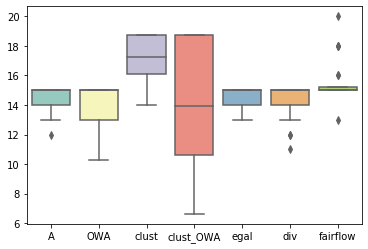

In [616]:
ax = sns.boxplot(x=np.array(["A","OWA","clust","clust_OWA","egal","div","fairflow"]),y=[combo_smallest[0],combo_smallest[1],combo_smallest[2],combo_smallest[3],combo_smallest[4],combo_smallest[5], smalst[0]], palette="Set3")

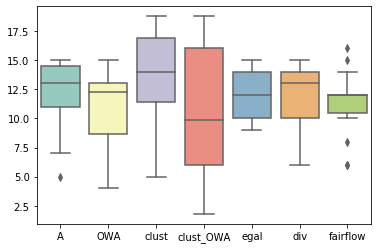

In [617]:
import seaborn as sns

ax = sns.boxplot(x=np.array(["A","OWA","clust","clust_OWA","egal","div","fairflow"]),y=[combo_small[0],combo_small[1],combo_small[2],combo_small[3],combo_small[4],combo_small[5], smal[0]], palette="Set3")

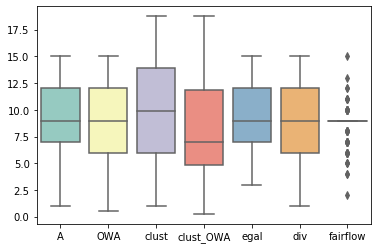

In [632]:
ax = sns.boxplot(x=np.array(["A","OWA","clust","clust_OWA","egal","div","fairflow"]),y=[combo_balanced[0],combo_balanced[1],combo_balanced[2],combo_balanced[3],combo_balanced[4],combo_balanced[5], bal[0]], palette="Set3")

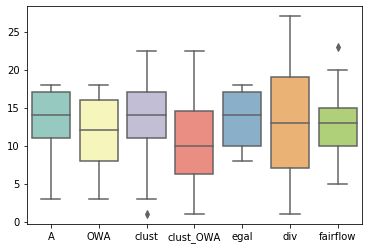

In [619]:
ax = sns.boxplot(x=np.array(["A","OWA","clust","clust_OWA","egal","div","fairflow"]),y=[combo_med[0],combo_med[1],combo_med[2],combo_med[3],combo_med[4],combo_med[5], me[0]], palette="Set3")

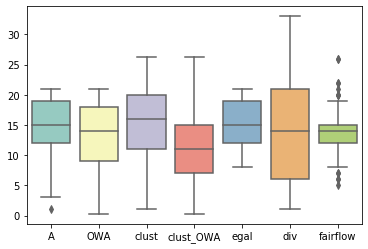

In [620]:
ax = sns.boxplot(x=np.array(["A","OWA","clust","clust_OWA","egal","div","fairflow"]),y=[combo_large[0],combo_large[1],combo_large[2],combo_large[3],combo_large[4],combo_large[5],lar[0]], palette="Set3")

In [631]:
start = timer()
bal=fairflow(balanced[0], R4, P4, 3, 3, 7)
end = timer()
print(end-start)


146
12.212197100016056


In [633]:
start = timer()
smalst=fairflow(smallest[0], R5, P5, 5, 3,7)
end = timer()
print(end-start)
start = timer()
smal=fairflow(small[0], R1, P1, 4, 3,7)
end = timer()
print(end-start)

24
0.5190702000109013
31
0.8202333000081126


In [634]:
start = timer()
lar=fairflow(large[0], R3, P3, 5, 2,5)
end = timer()
print(end-start)
start = timer()
me=fairflow(med[0], R2, P2, 5, 2, 5)
end = timer()
print(end-start)


200
82.6383163999999
158
38.70295909998822


In [635]:
print(sum(lar[0]))
print(np.mean(lar[0]))
print(np.min(lar[0]))
print(np.std(smalst[0]))

2783.0
13.845771144278608
5.0
1.4409680388158819
